# Data preparation for clustering

In [1]:
import pandas as pd 

customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

In [2]:
# Merge the datasets
merged_data = transactions.merge(customers, on='CustomerID', how='left')
merged_data = merged_data.merge(products, on='ProductID', how='left')

# Inspect the merged dataset
print("\nMerged Data Sample:")
print(merged_data.head())
print(merged_data.info())


Merged Data Sample:
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue  Price_x     CustomerName         Region  SignupDate  \
0      300.68   300.68   Andrea Jenkins         Europe  2022-12-03   
1      300.68   300.68  Brittany Harvey           Asia  2024-09-04   
2      300.68   300.68  Kathryn Stevens         Europe  2024-04-04   
3      601.36   300.68  Travis Campbell  South America  2024-04-11   
4      902.04   300.68    Timothy Perez         Europe  2022-03-15   

                       ProductName     Category  Price_y  
0  ComfortLiving Bluetooth Speaker  Electronics   300.68  
1  ComfortLiv

In [3]:
from sklearn.preprocessing import StandardScaler

# Aggregate transaction data for clustering
clustering_data = merged_data.groupby('CustomerID').agg({
    'TotalValue': 'sum',       # Total spending
    'Quantity': 'sum',         # Total products purchased
    'ProductID': 'nunique'     # Number of unique products purchased
}).reset_index()

# Merge with customer profile data
clustering_data = clustering_data.merge(customers, on='CustomerID', how='left')

# Select relevant numerical features
clustering_features = clustering_data[['TotalValue', 'Quantity', 'ProductID']]

# Standardize the data
scaler = StandardScaler()
clustering_features_scaled = scaler.fit_transform(clustering_features)
print("Data is prepared and scaled for clustering!")


Data is prepared and scaled for clustering!


# Perform clustering and calculate DBI

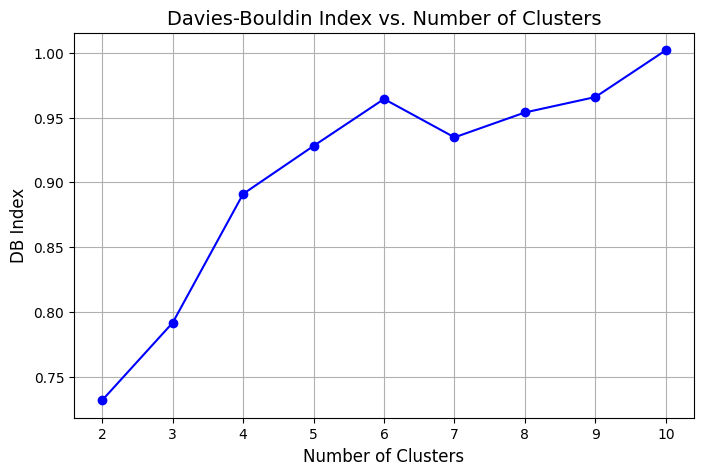

The optimal number of clusters is: 2


In [4]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt

# Test different numbers of clusters (2 to 10)
db_scores = []
cluster_range = range(2, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(clustering_features_scaled)
    db_score = davies_bouldin_score(clustering_features_scaled, cluster_labels)
    db_scores.append(db_score)

# Plot DBI scores
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, db_scores, marker='o', color='blue')
plt.title('Davies-Bouldin Index vs. Number of Clusters', fontsize=14)
plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('DB Index', fontsize=12)
plt.grid()
plt.show()

# Identify the optimal number of clusters
optimal_k = cluster_range[db_scores.index(min(db_scores))]
print(f"The optimal number of clusters is: {optimal_k}")


# Final clustering with k

In [5]:
# Apply K-Means with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clustering_data['Cluster'] = kmeans.fit_predict(clustering_features_scaled)

# Display sample data with cluster assignments
print(clustering_data.head())

  CustomerID  TotalValue  Quantity  ProductID        CustomerName  \
0      C0001     3354.52        12          5    Lawrence Carroll   
1      C0002     1862.74        10          4      Elizabeth Lutz   
2      C0003     2725.38        14          4      Michael Rivera   
3      C0004     5354.88        23          8  Kathleen Rodriguez   
4      C0005     2034.24         7          3         Laura Weber   

          Region  SignupDate  Cluster  
0  South America  2022-07-10        1  
1           Asia  2022-02-13        1  
2  South America  2024-03-07        1  
3  South America  2022-10-09        0  
4           Asia  2022-08-15        1  


# Visualizing the clusters

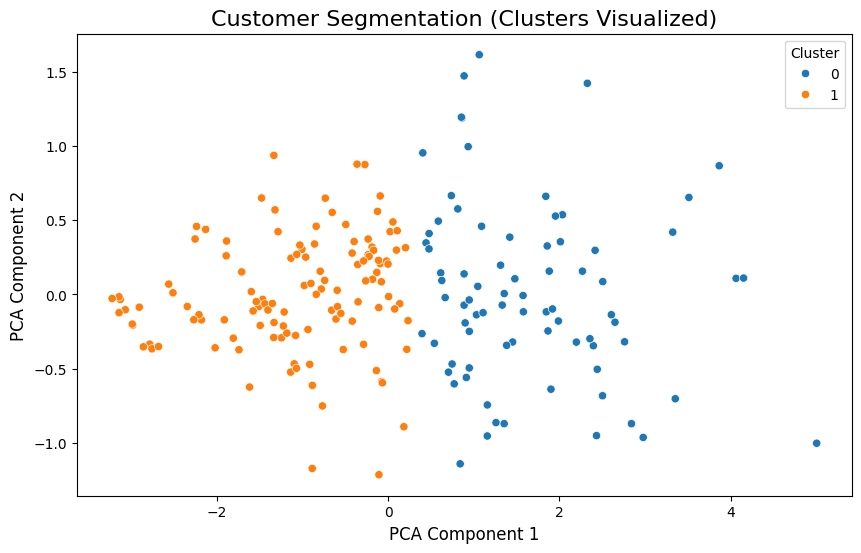

In [6]:
from sklearn.decomposition import PCA
import seaborn as sns

# Reduce dimensions for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(clustering_features_scaled)
clustering_data['PCA1'] = reduced_data[:, 0]
clustering_data['PCA2'] = reduced_data[:, 1]

# Plot clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='PCA1', y='PCA2', hue='Cluster', data=clustering_data, palette='tab10'
)
plt.title('Customer Segmentation (Clusters Visualized)', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=12)
plt.ylabel('PCA Component 2', fontsize=12)
plt.legend(title='Cluster', fontsize=10)
plt.show()